# Manga vs Classic Art Style Comic Images

Kaggle dataset

🥇 Goal is to classify comic art into Manga or Classic Style

https://www.kaggle.com/datasets/saralagrawal/manga-vs-classic-art-style-comic-images/data

We'll use two kinds of networks on this dataset:

1. Convolutional Neural Network built from scratch
2. Transfer Learning using VGG16


## Setup

### Import Libraries

In [ ]:
import os
from google.colab import userdata

os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

In [ ]:
import zipfile

import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!kaggle datasets download -d saralagrawal/manga-vs-classic-art-style-comic-images

Dataset URL: https://www.kaggle.com/datasets/saralagrawal/manga-vs-classic-art-style-comic-images
License(s): Apache 2.0
 98% 49.0M/49.8M [00:01<00:00, 34.0MB/s]
100% 49.8M/49.8M [00:01<00:00, 41.6MB/s]


In [ ]:
zip_path = "/content/manga-vs-classic-art-style-comic-images.zip"
with zipfile.ZipFile(zip_path, "r") as zip_ref:
  zip_ref.extractall(".")
  zip_ref.close()

### Load Dataset

In [ ]:
dataset_dir = "/content/Comics"

train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "validation")
test_dir = os.path.join(dataset_dir, "test")

print(f"Training Directory Size:{len(os.listdir(train_dir))}")
print(f"Validation Directory Size:{len(os.listdir(val_dir))}")
print(f"Test Directory Size:{len(os.listdir(test_dir))}")

Training Directory Size:2
Validation Directory Size:2
Test Directory Size:1


In [ ]:
os.path.isdir(dataset_dir)

True

In [ ]:
total_samples = 0

for dirname in ["train", "test", "validation"]:
  for root, subdir, files in os.walk(os.path.join(dataset_dir, dirname)):
    if len(subdir) == 0:

      print(f"Directory Name:{root}")

      num_samples = len(os.listdir(root))
      print(f"Number of sample images:{num_samples}")

      total_samples += num_samples

print(f"**Total number of sample images:{total_samples}**")

Directory Name:/content/Comics/train/classic
Number of sample images:686
Directory Name:/content/Comics/train/manga
Number of sample images:675
Directory Name:/content/Comics/test/mangavsclassic
Number of sample images:60
Directory Name:/content/Comics/validation/classic
Number of sample images:250
Directory Name:/content/Comics/validation/manga
Number of sample images:250
**Total number of sample images:1921**


♦ The dataset isn't very big. Data Augmentation will be necessary to ensure our network generalises properly

### Re-organize Test folder

In [ ]:
# Test Directory isn't organized in its class directories. Let's fix that.
import shutil

# Create two new directories based on the class names
for dir in ["classic", "manga"]:
  os.mkdir(os.path.join(test_dir, dir))

In [ ]:
# Move files based on their class name in file name
src_dir = os.path.join(test_dir, "mangavsclassic")

for f in os.listdir(src_dir):
  src_file = os.path.join(src_dir, f)
  if f.split("_")[0] == "classic":
    dest_dir = os.path.join(test_dir, "classic")
  if f.split("_")[0] == "manga":
    dest_dir = os.path.join(test_dir, "manga")

  dest_file = os.path.join(dest_dir, f)
  shutil.move(src_file, dest_file)
  print(f"{src_file} moved to {dest_dir}")

/content/Comics/test/mangavsclassic/manga_img900.jpg moved to /content/Comics/test/manga
/content/Comics/test/mangavsclassic/classic_img885.jpg moved to /content/Comics/test/classic
/content/Comics/test/mangavsclassic/manga_img392.jpg moved to /content/Comics/test/manga
/content/Comics/test/mangavsclassic/classic_img378.jpg moved to /content/Comics/test/classic
/content/Comics/test/mangavsclassic/classic_img274.jpg moved to /content/Comics/test/classic
/content/Comics/test/mangavsclassic/manga_img937.jpg moved to /content/Comics/test/manga
/content/Comics/test/mangavsclassic/classic_img876.jpg moved to /content/Comics/test/classic
/content/Comics/test/mangavsclassic/manga_img182.jpg moved to /content/Comics/test/manga
/content/Comics/test/mangavsclassic/manga_img201.jpg moved to /content/Comics/test/manga
/content/Comics/test/mangavsclassic/manga_img403.jpg moved to /content/Comics/test/manga
/content/Comics/test/mangavsclassic/classic_img696.jpg moved to /content/Comics/test/classic
/

In [ ]:
print(f'Num of samples in Classic:{len(os.listdir(os.path.join(test_dir, "classic")))}')
print(f'Num of samples in Manga:{len(os.listdir(os.path.join(test_dir, "classic")))}')

shutil.rmtree(os.path.join(test_dir, "mangavsclassic"))

Num of samples in Classic:30
Num of samples in Manga:30


## EDA on the dataset

### Explore different properties of image files

In [ ]:
# check file formats
formats = []
file_sizes = []

for dir in os.listdir(train_dir):
  dir_path = os.path.join(train_dir, dir)
  for f in os.listdir(dir_path):
    file_type = f.split('.')[-1]
    if file_type not in formats:
      formats.append(file_type)

    # inspect file size
    img = Image.open(os.path.join(dir_path, f))
    if img.size not in file_sizes:
      file_sizes.append(img.size)
    img.close()

print(f"File formats:{formats}")
print(f"Image sizes:{file_sizes}")

File formats:['jpg']
Image sizes:[(483, 280), (260, 280), (237, 280), (390, 280), (376, 280), (239, 280), (247, 280), (594, 280), (347, 280), (267, 280), (436, 280), (190, 280), (370, 280), (201, 280), (340, 280), (405, 280), (416, 280), (359, 280), (265, 280), (191, 280), (311, 280), (404, 280), (377, 280), (1066, 280), (264, 280), (328, 280), (173, 280), (368, 280), (186, 280), (781, 280), (273, 280), (184, 280), (160, 280), (525, 280), (298, 280), (342, 280), (364, 280), (213, 280), (569, 280), (235, 280), (1500, 1225), (316, 280), (520, 280), (243, 280), (339, 280), (333, 280), (290, 280), (259, 280), (428, 280), (462, 280), (219, 280), (279, 280), (393, 280), (1500, 852), (546, 280), (542, 280), (282, 280), (225, 280), (433, 280), (367, 280), (261, 280), (249, 280), (351, 280), (183, 280), (187, 280), (312, 280), (291, 280), (242, 280), (205, 280), (146, 280), (256, 280), (395, 280), (258, 280), (220, 280), (246, 280), (318, 280), (208, 280), (338, 280), (468, 280), (319, 280), (3

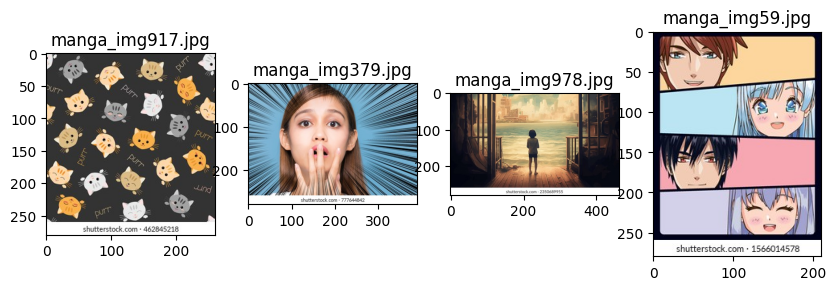

In [ ]:
plt.figure(figsize=(10, 10))

for idx, dirname in enumerate(["classic", "manga"]): #classic
  subdir = os.path.join(train_dir, dirname) #classic
  for i, f in enumerate(os.listdir(subdir)[:4]):
    img_file_path = os.path.join(subdir, f)
    axs = plt.subplot(2, 4, i + 1)
    img = Image.open(img_file_path)
    img_to_arr = np.array(img).astype("uint8")
    plt.imshow(img_to_arr)
    plt.title(f)

In [ ]:
# how many types of sizes and height are there and what is the average size
import pandas as pd

img_size = {}
img_size['height'] = []
img_size['width'] = []

for dirname in ["classic", "manga"]:
  subdir = os.path.join(train_dir, dirname)
  for f in os.listdir(subdir):
    img = Image.open(os.path.join(subdir, f))
    img_height, img_width = img.size
    img_size['height'].append(img_height)
    img_size['width'].append(img_width)

df = pd.DataFrame(img_size, index=range(len(img_size['height'])))
df.head()

,height,width
0,483,280
1,260,280
2,260,280
3,260,280
4,260,280


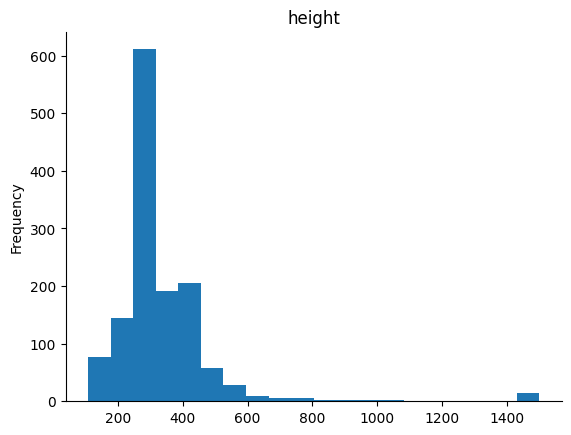

In [ ]:
from matplotlib import pyplot as plt
df['height'].plot(kind='hist', bins=20, title='height')
plt.gca().spines[['top', 'right',]].set_visible(False)

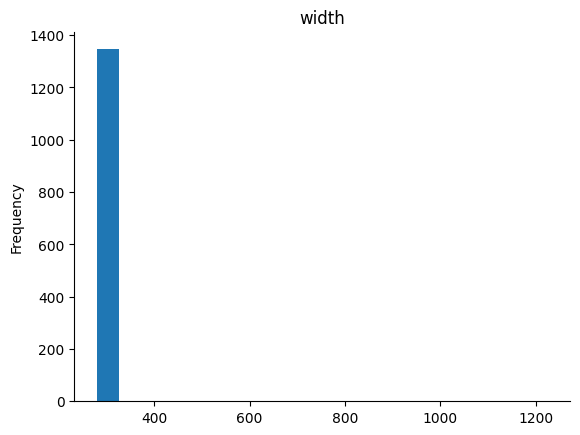

In [ ]:
df['width'].plot(kind='hist', bins=20, title='width')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Check image channels
for idx, dirname in enumerate(["classic", "manga"]): #classic
  subdir = os.path.join(train_dir, dirname)
  for i, f in enumerate(os.listdir(subdir)[:4]):
    img_file_path = os.path.join(subdir, f)
    img = Image.open(img_file_path)

    img_mode = img.mode

    if img_mode == "RGB":
      num_channels = 3
    elif img_mode == "RGBA":
      num_channels = 4
    elif img_mode == "L":
      num_channels = 1
    else:
      num_channels=None

    print(f"File {f} has number of channels={num_channels}")

File classic_img762.jpg has number of channels=3
File classic_img157.jpg has number of channels=3
File classic_img849.jpg has number of channels=3
File classic_img469.jpg has number of channels=3
File manga_img917.jpg has number of channels=3
File manga_img379.jpg has number of channels=3
File manga_img978.jpg has number of channels=3
File manga_img59.jpg has number of channels=3


## Create a tf.data.Dataset object from the dataset

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)
NUM_CLASSES = 2

In [ ]:
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode="int",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 1361 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 60 files belonging to 2 classes.


## Preprocess Data

### Rescaling Layer

In [ ]:
rescaling_layer = tf.keras.layers.Rescaling(1.0/255)

### Data Augmentation

In [ ]:
data_augmentation_layers = [
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
]

def apply_data_augmentation(images):
  for layer in data_augmentation_layers:
    augmented_images = layer(images)
  return augmented_images

(256, 256, 3) ()


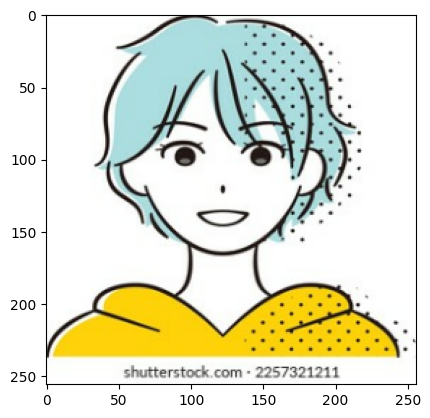

In [ ]:
# original image
for images, labels in raw_train_ds.take(1):
  print(images[0].shape, labels[0].shape)
  sample = images[0]
  plt.imshow(np.array(sample).astype("uint8"))

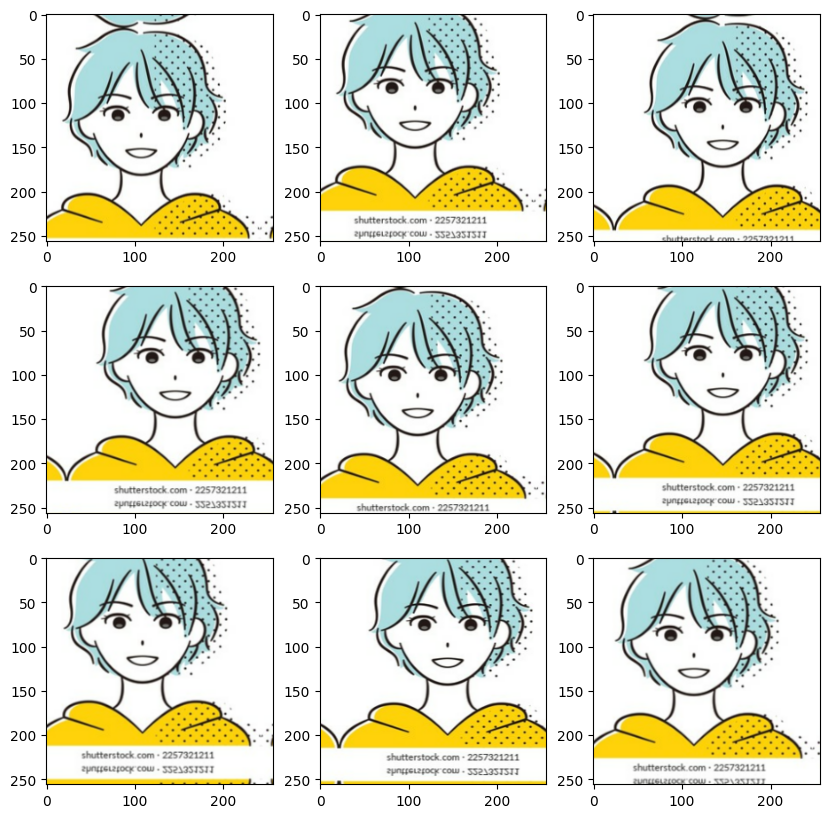

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = apply_data_augmentation(sample)
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(np.array(augmented_image).astype("uint8"))

In [ ]:
def preprocess_training_data(image_batch, label_batch):
  image_batch = apply_data_augmentation(image_batch)
  #label_batch = tf.one_hot(label_batch, NUM_CLASSES)
  return image_batch, label_batch

def preprocess_test_data(image_batch, label_batch):
  #label_batch = tf.one_hot(label_batch, NUM_CLASSES)
  return image_batch, label_batch

In [ ]:
for i, l in raw_train_ds.take(1):
  new_l = tf.one_hot(l[0],depth=2)
type(new_l)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
# Apply data augmentation
train_ds = raw_train_ds.map(preprocess_training_data, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=1000).cache().prefetch(tf.data.AUTOTUNE)
val_ds = raw_val_ds.map(preprocess_training_data, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=1000).cache().prefetch(tf.data.AUTOTUNE)
test_ds = raw_test_ds.map(preprocess_test_data, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=1000)

## Model Architecture

#### Baseline Model

Training a model from scratch

In [ ]:
from keras import layers, models
from keras import losses, metrics, optimizers

In [ ]:
PROJECT_DIR = './IMG_manga_vs_classic'

In [ ]:
os.mkdir(PROJECT_DIR)

In [ ]:
def make_model(input_shape, num_classes, name):
  inputs = layers.Input(shape=input_shape)

  x = rescaling_layer(inputs)
  x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="valid", activation="relu")(x)
  x = layers.MaxPool2D(pool_size=(2, 2))(x)
  x = layers.BatchNormalization()(x)

  x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.BatchNormalization()(x)

  x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.BatchNormalization()(x)

  # Densely connected layers
  x = layers.Flatten()(x) # convert 3D feature maps into 1D vectors
  x = layers.Dense(64, activation="relu")(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)

  model = models.Model(inputs, outputs, name=name)

  return model

In [ ]:
# save best performing model for baseline comparison
save_path = os.path.join(PROJECT_DIR, "model_experiments")
def create_model_checkpoint(model_name, save_path=save_path):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=1,
                                            save_best_only=True)

In [ ]:
def plot_model(model):
    return tf.keras.utils.plot_model(model,
                              to_file=os.path.join(PROJECT_DIR,f"{model.name}.png"),
                              show_shapes=True)

In [ ]:
EPOCHS = 10
def compile_and_fit(model, epochs):
  model.compile(loss=losses.BinaryCrossentropy(),
                optimizer=optimizers.Adam(),
                metrics=metrics.BinaryAccuracy())

  history = model.fit(train_ds,
            epochs=epochs,
            verbose=1,
            validation_data=val_ds,
            callbacks=[create_model_checkpoint(model_name=model.name)])

  return history

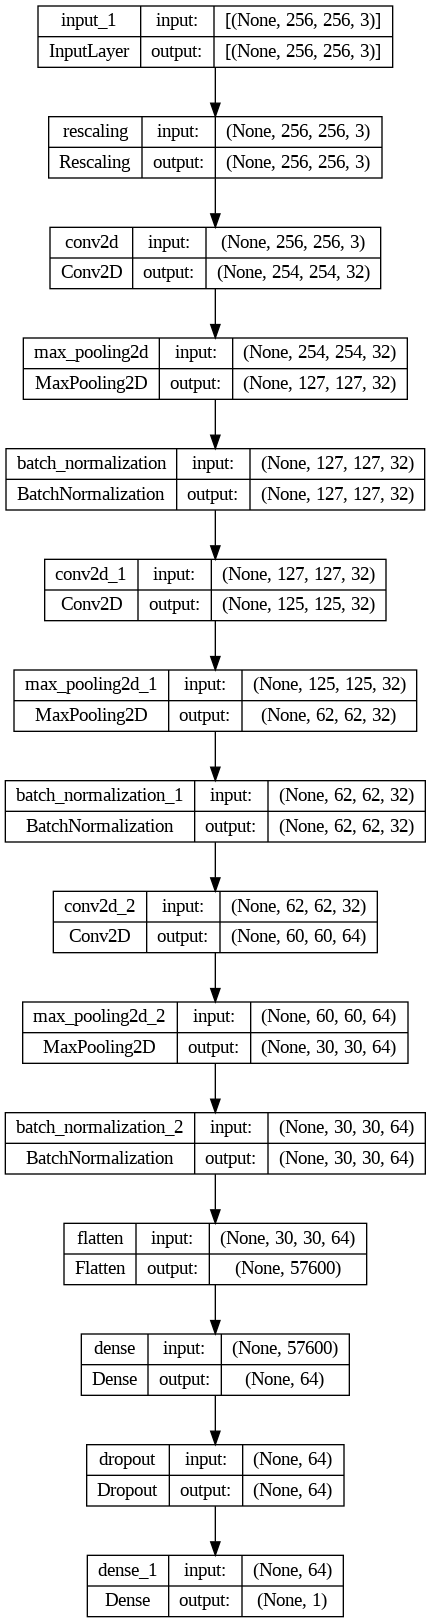

In [ ]:
model = make_model(input_shape=IMAGE_SIZE + (3,), num_classes=NUM_CLASSES, name='model_1_baseline')
plot_model(model)

In [ ]:
history = compile_and_fit(model)

Epoch 1/10
42/43 [============================>.] - ETA: 0s - loss: 4.3291 - binary_accuracy: 0.6321
Epoch 1: val_loss improved from inf to 1.12435, saving model to ./IMG_manga_vs_classic/model_experiments/model_1_baseline
43/43 [==============================] - 13s 122ms/step - loss: 4.3349 - binary_accuracy: 0.6319 - val_loss: 1.1244 - val_binary_accuracy: 0.5040
Epoch 2/10
43/43 [==============================] - ETA: 0s - loss: 2.1572 - binary_accuracy: 0.6694
Epoch 2: val_loss improved from 1.12435 to 1.00560, saving model to ./IMG_manga_vs_classic/model_experiments/model_1_baseline
43/43 [==============================] - 3s 78ms/step - loss: 2.1572 - binary_accuracy: 0.6694 - val_loss: 1.0056 - val_binary_accuracy: 0.5100
Epoch 3/10
43/43 [==============================] - ETA: 0s - loss: 1.2984 - binary_accuracy: 0.7024
Epoch 3: val_loss improved from 1.00560 to 0.89192, saving model to ./IMG_manga_vs_classic/model_experiments/model_1_baseline
43/43 [==========================

In [ ]:
EPOCHS=30
history = compile_and_fit(model, epochs=EPOCHS)

Epoch 1/30
43/43 [==============================] - ETA: 0s - loss: 0.4641 - binary_accuracy: 0.8773
Epoch 1: val_loss improved from inf to 3.05740, saving model to ./IMG_manga_vs_classic/model_experiments/model_1_baseline
43/43 [==============================] - 6s 83ms/step - loss: 0.4641 - binary_accuracy: 0.8773 - val_loss: 3.0574 - val_binary_accuracy: 0.6780
Epoch 2/30
43/43 [==============================] - ETA: 0s - loss: 0.2809 - binary_accuracy: 0.8861
Epoch 2: val_loss did not improve from 3.05740
43/43 [==============================] - 2s 41ms/step - loss: 0.2809 - binary_accuracy: 0.8861 - val_loss: 4.1378 - val_binary_accuracy: 0.6840
Epoch 3/30
43/43 [==============================] - ETA: 0s - loss: 0.2710 - binary_accuracy: 0.9089
Epoch 3: val_loss did not improve from 3.05740
43/43 [==============================] - 2s 41ms/step - loss: 0.2710 - binary_accuracy: 0.9089 - val_loss: 6.5608 - val_binary_accuracy: 0.6640
Epoch 4/30
43/43 [==============================]

Observations:

* Baseline Model only yielded a validation accuracy of 68% at this best performing epoch with lowest observed validation loss.

* Obviously, there isn't enough data to train a model from scratch.

⏭ Next, fine tune an existing model on top of this dataset - transfer learning approach.

### Fine-Tuning

In [ ]:
def fine_tune_model(input_shape, num_classes, base_model, name):
  inputs = tf.keras.Input(shape=input_shape)
  x = rescaling_layer(inputs)
  x = base_model(x, training=False)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units=1, activation="sigmoid")(x)

  model = models.Model(inputs, outputs, name=name)

  return model

#### EfficientNetB0

Using Imagenet weights with the base model

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMAGE_SIZE + (3,), include_top=False, weights="imagenet")
base_model.trainable=False

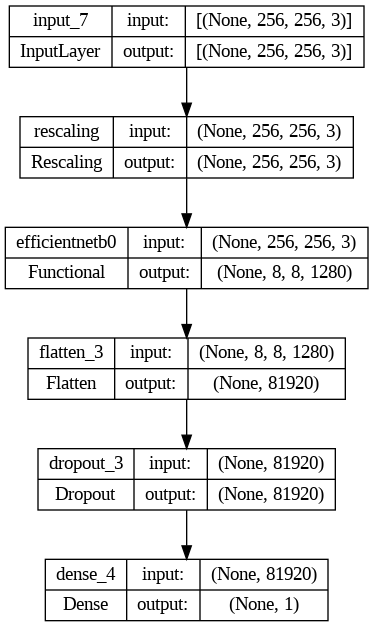

In [ ]:
model = fine_tune_model(input_shape=IMAGE_SIZE + (3,), num_classes=NUM_CLASSES, base_model=base_model, name="model_2_FT_EfficientNetB0")
plot_model(model)

In [ ]:
model.summary(show_trainable=True)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 256, 256, 3)       0         Y          
                                                                            
 efficientnetb0 (Functional  (None, 8, 8, 1280)        4049571   N          
 )                                                                          
                                                                            
 flatten_2 (Flatten)         (None, 81920)             0         Y          
                                                                            
 dropout_2 (Dropout)         (None, 81920)             0         Y          
                                                           

In [ ]:
# Train the top layer
EPOCHS = 10
history = compile_and_fit(model, epochs=EPOCHS)

Epoch 1/10
43/43 [==============================] - ETA: 0s - loss: 1.8522 - binary_accuracy: 0.5092
Epoch 1: val_loss improved from inf to 1.18247, saving model to ./IMG_manga_vs_classic/model_experiments/model_2_FT_EfficientNetB0
43/43 [==============================] - 35s 672ms/step - loss: 1.8522 - binary_accuracy: 0.5092 - val_loss: 1.1825 - val_binary_accuracy: 0.5000
Epoch 2/10
43/43 [==============================] - ETA: 0s - loss: 0.9843 - binary_accuracy: 0.5092
Epoch 2: val_loss improved from 1.18247 to 1.12523, saving model to ./IMG_manga_vs_classic/model_experiments/model_2_FT_EfficientNetB0
43/43 [==============================] - 26s 628ms/step - loss: 0.9843 - binary_accuracy: 0.5092 - val_loss: 1.1252 - val_binary_accuracy: 0.5000
Epoch 3/10
43/43 [==============================] - ETA: 0s - loss: 0.8810 - binary_accuracy: 0.5114
Epoch 3: val_loss improved from 1.12523 to 0.85271, saving model to ./IMG_manga_vs_classic/model_experiments/model_2_FT_EfficientNetB0
43/4

Observations:

Replaced EfficientNetB0's classifier and reran the model compilation and fit.

The results were worse than training the model from scratch.

⏭ Next: Let's do a round of fine-tuning on entire model

In [ ]:
# changing the last layer to only produce logits
def fine_tune_model(input_shape, num_classes, base_model, name):
  inputs = tf.keras.Input(shape=input_shape)
  x = rescaling_layer(inputs)
  x = base_model(x, training=False)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units=1)(x)

  model = models.Model(inputs, outputs, name=name)

  return model

In [ ]:
def compile_and_fit(model, epochs):
  model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
                optimizer=optimizers.Adam(),
                metrics=metrics.BinaryAccuracy())

  history = model.fit(train_ds,
            epochs=epochs,
            verbose=1,
            validation_data=val_ds,
            callbacks=[create_model_checkpoint(model_name=model.name)])

  return history

In [ ]:
# this will ensure the base model runs in inference mode because training=False has been set in the layer
# BatchNorm layers will be running in inference as well

base_model.trainable=True

In [ ]:
EPOCHS = 5
model = fine_tune_model(input_shape=IMAGE_SIZE + (3,), num_classes=NUM_CLASSES, base_model=base_model, name="model_3_FT_EfficientNetB0")
history = compile_and_fit(model, epochs=EPOCHS)

Epoch 1/5
43/43 [==============================] - ETA: 0s - loss: 0.7951 - binary_accuracy: 0.5129
Epoch 1: val_loss improved from inf to 0.69315, saving model to ./IMG_manga_vs_classic/model_experiments/model_3_FT_EfficientNetB0
43/43 [==============================] - 84s 1s/step - loss: 0.7951 - binary_accuracy: 0.5129 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 2/5
43/43 [==============================] - ETA: 0s - loss: 0.7102 - binary_accuracy: 0.5033
Epoch 2: val_loss did not improve from 0.69315
43/43 [==============================] - 9s 214ms/step - loss: 0.7102 - binary_accuracy: 0.5033 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 3/5
43/43 [==============================] - ETA: 0s - loss: 10.6993 - binary_accuracy: 0.4805
Epoch 3: val_loss did not improve from 0.69315
43/43 [==============================] - 9s 215ms/step - loss: 10.6993 - binary_accuracy: 0.4805 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 4/5
43/43 [=======================